<a href="https://colab.research.google.com/github/NickKar30/GM-HSE-AI-masters-course/blob/main/Hometasks/Base/GenDL_HT1_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание - 1 (базовая группа)

В этом домашнем задании вы потренируетесь решать задачу speech-to-text.

Вы не будете тренировать сложную архитектуру с нуля, а попробуете решить эту задачу, пройдя по пайплайну, в котором задача разбита на несколько простых шагов.

- В этом задании мы призываем вас по-максимуму использовать документацию моделей и получить опыт написания кода без заготовок

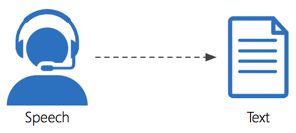

In [1]:
%mkdir -p /content/host/
%cd /content/host/
%ls

/content/host
data_russian_speech/  result_array.json                  urls_normalized.tsv
models/               russian_spell_correction_dataset/


In [2]:
# Установка всех необходимых пакетов
%pip install -q pandas transformers datasets torchaudio torcheval evaluate openai huggingface_hub

# не обновлять pandas выше 2.2.2 - требуется для Google Collab

## Шаг 1 (1 балл)

* Возьмите датасет https://disk.yandex.ru/d/v2Hipv7XG4fEDQ, содержащий русскоязычные аудиозаписи

* Примените модель [whisper-small](https://huggingface.co/openai/whisper-small) из HF для определения сказанного в аудио.

* Выведите результат работы модели для 10 случайных аудио из датасета

Не стесняйтесь пользоваться документацией и источниками знаний из интернета!

In [3]:
import os
import random
import torch
import torchaudio
from pathlib import Path
import csv

from transformers import WhisperProcessor, WhisperForConditionalGeneration


### Загрузим список URL с файлами датасета

In [4]:
# предварительно сохранить файл https://disk.yandex.ru/d/v2Hipv7XG4fEDQ как `urls_normalized.tsv`

DATA_ROOT = Path("data_russian_speech")
DATA_ROOT.mkdir(parents=True, exist_ok=True)
TSV_PATH = Path("./urls_normalized.tsv")

urls = []

with TSV_PATH.open("r", encoding="utf-8") as f:
    tsv_reader = csv.reader(f, delimiter="\t")
    for row in tsv_reader:
        urls.append(row[0].strip())

print(f"Найдено {len(urls)} URL для скачивания.")


Найдено 100 URL для скачивания.


### Скачаем аудио-файлы

In [5]:
import requests
from tqdm.auto import tqdm

def download_file(url: str, dest_path: Path):
    """Загрузка одного файла (с прогресс-баром)."""
    filename = url.split("/")[-1] + ".wav"
    target_file = dest_path / filename

    if target_file.is_file():
        print(f"- Уже существует: {filename}")
        return

    # Потоковое скачивание, чтобы не грузить много в память
    with requests.get(url, stream=True, timeout=30) as r:
        r.raise_for_status()
        total = int(r.headers.get("content-length", 0))
        with tqdm(total=total, unit="B", unit_scale=True, desc=filename) as pbar:
            with open(target_file, "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    if chunk:  # могут быть пустые - keep-alive
                        f.write(chunk)
                        pbar.update(len(chunk))

    print(f"+ Загружен: {filename}")

for url in urls:
    try:
        download_file(url, DATA_ROOT)
    except Exception as e:
        print(f"Х Ошибка загрузки {url}: {e}")


- Уже существует: 197f271b-b23f-4ee0-b240-e956a172d7af.wav
- Уже существует: 3d8c8d43-f7f2-479b-a857-c90faa5e2faf.wav
- Уже существует: 45161c4c-3f2c-4638-940e-a69404074ebb.wav
- Уже существует: 3c0ebd62-2cc1-4c9c-be63-5733511a11cd.wav
- Уже существует: 6385560c-7068-45c2-9ba7-9e061249e0a4.wav
- Уже существует: c4f3178c-14b2-44f8-b36e-f34a47520e10.wav
- Уже существует: 0f2ef6c9-3dec-45ae-b456-8115c9419044.wav
- Уже существует: 4711cdac-8181-4f3c-8889-77cf408f3ff2.wav
- Уже существует: 37e917e1-1fdf-4064-a74f-57a84bcb28b9.wav
- Уже существует: d203c652-509b-4c41-bdaf-f374e1c3c87e.wav
- Уже существует: c53908cc-adb1-418b-b68b-f67094fc4afd.wav
- Уже существует: a6bab1dc-059b-4f93-a2ec-baef363ddcea.wav
- Уже существует: dc7eedda-8db3-4ea5-abcd-d8ecb9fec734.wav
- Уже существует: 29c0f7f4-9701-4e19-a4cd-874ec5397be1.wav
- Уже существует: fcceeeb4-5bb7-460a-853c-99c3c7bd5aef.wav
- Уже существует: 969c8460-29a8-4c6a-ac71-bc729a6d1f3d.wav
- Уже существует: 22d8f014-0f11-447a-8133-fe1fb89c3e29.w

### Вспомогательные функции загрузки аудио-файлов

In [6]:
import wave
import numpy as np
import torch

def load_wav_file(filepath):
    """Считывание WAV-файла и получение тензора PyTorch"""
    with wave.open(filepath, 'rb') as wav_file:
        # Параметры аудиофайла
        channels = wav_file.getnchannels()
        sample_width = wav_file.getsampwidth()
        framerate = wav_file.getframerate()
        frames = wav_file.getnframes()
        
        # Считаем аудиоданные
        raw_audio = wav_file.readframes(frames)
        
        # Конвертируем в numpy array
        if sample_width == 1:
            dtype = np.uint8
        elif sample_width == 2:
            dtype = np.int16
        elif sample_width == 4:
            dtype = np.int32
        else:
            raise ValueError(f'Неподдерживаемый "sample width": {sample_width}')
            
        audio_data = np.frombuffer(raw_audio, dtype=dtype)
        
        # Reshape, если многоканальное аудио
        if channels > 1:
            audio_data = audio_data.reshape(-1, channels)
            
        # Нормализация к диапазону [-1, 1]
        if dtype == np.uint8:
            audio_data = (audio_data.astype(np.float32) - 128) / 128
        else:
            audio_data = audio_data.astype(np.float32) / np.iinfo(dtype).max
            
        tensor = torch.from_numpy(audio_data)
        
        # Приведение к структуре (channels, samples) для PyTorch
        if len(tensor.shape) == 1:
            tensor = tensor.unsqueeze(0)  # добавить измерение
        else:
            tensor = tensor.transpose(0, 1)  # переставить измерения (samples, channels) -> (channels, samples)
            
        return tensor, framerate

# тестовый 
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
audio_tensor, sample_rate = load_wav_file("./data_russian_speech/00760e69-35b8-4c65-84f6-c1d0e82907c2.wav")
audio_tensor = audio_tensor.to(device)

print(f"Загружено: {audio_tensor.shape} @ {sample_rate}Hz")


Загружено: torch.Size([1, 36160]) @ 16000Hz


In [7]:
import torchaudio
def load_audio(path: str, target_sr: int = 16000):
    wav, sr = load_wav_file(path)
    # Многоканальное усредним до "моно"
    if wav.shape[0] > 1:
        wav = wav.mean(dim=0, keepdim=True)
    # пересэмплируйте имеющиеся аудио в 16 kHz - пример кода ниже, можете его менять
    if sr != target_sr:
        wav = torchaudio.functional.resample(wav, orig_freq=sr, new_freq=target_sr)
        sr = target_sr
    return wav.squeeze(0), sr


### Подготовка модели Whisper

In [10]:
import os
from dotenv import load_dotenv
from google.colab import userdata

try:
    # Если в Google Colab, то используем userdata
    API_KEY = userdata.get('OPENROUTER_API_KEY')
    HF_TOKEN = userdata.get('HUGGINGFACE_TOKEN')
except Exception as e:  # если нет usertada, то будет исключение
    # Тогда читаем из .env файла в текущей директории /content/host/
    load_dotenv()
    API_KEY = os.getenv('OPENROUTER_API_KEY')
    HF_TOKEN = os.getenv('HUGGINGFACE_TOKEN')

# Для теста можно задать ключи вручную
if API_KEY is None:
    API_KEY = "---- ВПИШИТЕ СЮДА КЛЮЧ ----"
if HF_TOKEN is None:
    HF_TOKEN = "---- ВПИШИТЕ СЮДА КЛЮЧ ----"

os.environ["OPENROUTER_API_KEY"] = API_KEY
os.environ["HF_TOKEN"] = HF_TOKEN
MODEL_NAME = "deepseek/deepseek-chat-v3.1:free"

> При наличии токена HF_TOKEN почему-то иногда подключение к HF зависает.
> Помогает перезапуск ячейки.

In [12]:
model_name = "openai/whisper-small"

# загрузка пре-процессора (токенизатор и конвертер в mel-спектрограммы)
processor = WhisperProcessor.from_pretrained(model_name)
# загрузка самой модели 
model = WhisperForConditionalGeneration.from_pretrained(model_name).to(device)
# перевод в режим инференса
model.eval()

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 768)
      (layers): ModuleList(
        (0-11): 12 x WhisperEncoderLayer(
          (self_attn): WhisperAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (f

### Запуск распознавания аудио

In [13]:
# audio_dir = Path("data_russian_speech")
wav_paths = list(DATA_ROOT.rglob("*.wav"))

print(f"Найдено {len(wav_paths)} аудиофайлов для обработки")

for i, p in enumerate(wav_paths):
    print(f"Обрабатывается файл {i+1}/{len(wav_paths)}: {p.name}")
    
    wav, sr = load_audio(str(p))

    inputs = processor(wav, sampling_rate=sr, return_tensors="pt")
    input_features = inputs.input_features.to(model.device)
    
    # Создаем attention_mask если его нет
    if hasattr(inputs, 'attention_mask') and inputs.attention_mask is not None:
        attention_mask = inputs.attention_mask.to(model.device)
    else:
        # Создаем маску внимания для всех элементов (все единицы)
        attention_mask = torch.ones(input_features.shape[:2], dtype=torch.long, device=model.device)

    # Генерация выходных токенов
    predicted_ids = model.generate(
        input_features, 
        attention_mask=attention_mask,
        language="ru", 
        task="transcribe"
    )

    # Декодирование в текст
    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    
    # Сохраняем транскрипцию в файл
    txt_filename = p.stem + ".txt"  # p.stem дает имя файла без пути и без расширения
    txt_path = DATA_ROOT / txt_filename
    
    with open(txt_path, 'w', encoding='utf-8') as f:
        f.write(transcription)
    
    print(f"Транскрипция сохранена в: {txt_filename}")

print("Все файлы обработаны!")



Найдено 100 аудиофайлов для обработки
Обрабатывается файл 1/100: 86cae6ee-fe19-43b7-b6c7-cd30736167b1.wav
Транскрипция сохранена в: 86cae6ee-fe19-43b7-b6c7-cd30736167b1.txt
Обрабатывается файл 2/100: 37e917e1-1fdf-4064-a74f-57a84bcb28b9.wav
Транскрипция сохранена в: 37e917e1-1fdf-4064-a74f-57a84bcb28b9.txt
Обрабатывается файл 3/100: 00760e69-35b8-4c65-84f6-c1d0e82907c2.wav
Транскрипция сохранена в: 00760e69-35b8-4c65-84f6-c1d0e82907c2.txt
Обрабатывается файл 4/100: d6b51378-81b8-4b1f-8f80-0beef4a10592.wav
Транскрипция сохранена в: d6b51378-81b8-4b1f-8f80-0beef4a10592.txt
Обрабатывается файл 5/100: df8e6c78-0227-435c-92d0-b884bd61c91f.wav
Транскрипция сохранена в: df8e6c78-0227-435c-92d0-b884bd61c91f.txt
Обрабатывается файл 6/100: ed83b5df-882e-45ce-80b5-80a174a1c10c.wav
Транскрипция сохранена в: ed83b5df-882e-45ce-80b5-80a174a1c10c.txt
Обрабатывается файл 7/100: 53085fa6-1df6-4d46-ae00-4ce2b89ac0ca.wav
Транскрипция сохранена в: 53085fa6-1df6-4d46-ae00-4ce2b89ac0ca.txt
Обрабатывается фа

### Отображение 10 рандомных транскрипций

In [16]:
import random

# фильтруем файлы от последующих шагов
txt_files = [
    f for f in DATA_ROOT.rglob("*.txt") if not f.name.endswith("_t5.txt") and not f.name.endswith("_t5_ft.txt")
]
sample_txt_files = random.sample(txt_files, k=min(10, len(txt_files)))

print("10 случайных транскрипций:")
print("=" * 50)

for txt_file in sample_txt_files:
    with open(txt_file, "r", encoding="utf-8") as f:
        transcription = f.read().strip()

    print(f"Файл: {txt_file.name}")
    print(f"Транскрипция: {transcription}")
    print("-" * 40)


10 случайных транскрипций:
Файл: 2e069c1d-11ba-4a51-84b1-f182b8a2999a.txt
Транскрипция: Олеша Юрий Карлович
----------------------------------------
Файл: 2b9c598f-c08f-43eb-ac28-72cf962a9a05.txt
Транскрипция: Ирония судьбы или с лёгким паром
----------------------------------------
Файл: ab7118eb-d4fc-419e-bf99-b01b3886d09a.txt
Транскрипция: Крошенинников Степан Петрович
----------------------------------------
Файл: 4bd0ad25-e86a-4275-85b6-4d11ac96cfdc.txt
Транскрипция: Мой отец и мой сын
----------------------------------------
Файл: bbc64f47-2cfe-4cce-944d-2022fef45357.txt
Транскрипция: 3. Идиота
----------------------------------------
Файл: 0911b405-a657-46c2-8ab7-b8d3d0128510.txt
Транскрипция: Гайя не кумжи
----------------------------------------
Файл: d5bd3785-733a-4a95-b3ba-4d80ece002ee.txt
Транскрипция: Однажды в Америке
----------------------------------------
Файл: ca50a690-f1af-4a75-84e7-a8b121eff5e7.txt
Транскрипция: Джон Гудман
----------------------------------------
Ф

## Шаг 2 (1 балл)

Текст распознается с ошибками.
Попробуйте исправить ошибки с помощью готовой (предобученной) модели spell correction.

Выведите на экран 10 текстов с предыдущего шага и их исправления с помощью модели https://huggingface.co/UrukHan/t5-russian-spell.

In [17]:
# ваш код здесь
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

t5_tokenizer = AutoTokenizer.from_pretrained("UrukHan/t5-russian-spell")
t5_model = AutoModelForSeq2SeqLM.from_pretrained("UrukHan/t5-russian-spell")
t5_model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [18]:
# тестовый
input_ids = t5_tokenizer(
    "Полмакартни", return_tensors="pt"
).input_ids.to(device)  
outputs = t5_model.generate(input_ids)
print(t5_tokenizer.decode(outputs[0], skip_special_tokens=True))

Пол Маккартни


In [19]:
# audio_dir = Path("data_russian_speech")
txt_files = [
    f for f in DATA_ROOT.rglob('*.txt')
    if not f.name.endswith('_t5.txt') and not f.name.endswith('_t5_ft.txt')
]

for txt_file in tqdm(txt_files):
    with open(txt_file, 'r', encoding='utf-8') as f:
        transcription = f.read().strip()
        input_ids = t5_tokenizer(transcription, return_tensors="pt").input_ids.to(device)
        outputs = t5_model.generate(input_ids)
        corrected_text = t5_tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # save to file
        new_filename = txt_file.stem + "_t5.txt" 
        new_path = DATA_ROOT / new_filename
        with open(new_path, 'w', encoding='utf-8') as f:
            f.write(corrected_text)
    


  0%|          | 0/100 [00:00<?, ?it/s]

In [20]:
import random

txt_files = list(DATA_ROOT.rglob("*_t5.txt"))
sample_txt_files = random.sample(txt_files, k=min(10, len(txt_files)))

print('10 случайных "скорректированных" транскрипций:')
print("=" * 50)

for txt_file in sample_txt_files:
    with open(txt_file, 'r', encoding='utf-8') as f:
        transcription = f.read().strip()
    
    print(f"Файл: {txt_file.name}")
    print(f"Транскрипция: {transcription}")
    print("-" * 40)

10 случайных "скорректированных" транскрипций:
Файл: 00760e69-35b8-4c65-84f6-c1d0e82907c2_t5.txt
Транскрипция: Помни, Помни.
----------------------------------------
Файл: d6b51378-81b8-4b1f-8f80-0beef4a10592_t5.txt
Транскрипция: Otis Redding
----------------------------------------
Файл: 6b061312-1923-4924-97de-21e31d6f5861_t5.txt
Транскрипция: Синявский Андрей Донатович
----------------------------------------
Файл: 373c13d2-0039-4ca1-a549-1563d2a8ef0a_t5.txt
Транскрипция: Крестный отец 2
----------------------------------------
Файл: c53908cc-adb1-418b-b68b-f67094fc4afd_t5.txt
Транскрипция: Брайан Брайан Адамс
----------------------------------------
Файл: 86cae6ee-fe19-43b7-b6c7-cd30736167b1_t5.txt
Транскрипция: Жан-Поль-Сартер
----------------------------------------
Файл: 51c8ac21-4179-4590-9c62-de34065cbaeb_t5.txt
Транскрипция: Бил на и.
----------------------------------------
Файл: 47b9b402-e832-438d-ad85-3f7375867e4a_t5.txt
Транскрипция: КОМУ ПОРТЕРТЕР
-----------------------

## Шаг 3 (2 балла)

Соберите данные для дообучения модели выше. Для дообучения мы предлагаем вам использовать бесплатный api Groq: https://console.groq.com/docs/quickstart

Разберитесь с тем как пользоваться api (мы немного поможем вам с этим кодом ниже) и с его помощью соберите датасет (можно в несколько запросов).

- **0.5 балла** ставится за сбор датасета размером >1000 строк и сохранение в локальный файл/файлы

- **еще 0.5 балла** ставится за [создание huggingface dataset](https://huggingface.co/docs/datasets/create_dataset) (через использование библиотек datasets и huggingface) и [сохранение собранного датасета напрямую в HuggingFace](https://huggingface.co/docs/datasets/upload_dataset)

- **еще 1 балл** ставится за сбор датасета размером >1000 строк, на котором путем дообучения получится увеличить качество исправления опечаток в поставленной задаче (см. шаг 6) по сравнению с качеством прогноза той же, но предобученной модели

P.S. Если у Вас нет VPN, то можете воспользоваться другой LLM на Ваш выбор (можно, например, этим https://ollama.com/).

### Ключи доступа к модели

Следующая ячейка инициализирует ключи доступа к OpenRouter и HuggingFace.  
Ключи считываются либо из секретов Google Collab (если достпен), либо из локального файла `.env`

### Проверка подключения к OpenRouter

In [21]:
from openai import OpenAI

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=API_KEY
)

completion = client.chat.completions.create(
  # extra_headers={
  #   "HTTP-Referer": "<YOUR_SITE_URL>", # Optional. Site URL for rankings on openrouter.ai.
  #   "X-Title": "<YOUR_SITE_NAME>", # Optional. Site title for rankings on openrouter.ai.
  # },
  model=MODEL_NAME,
  messages=[
    {
      "role": "user",
      "content": "Привет! Поработаем сегодня?"
    }
  ]
)

print(completion.choices[0].message.content)


Привет! Конечно, поработаем. 😊

Что у нас на повестке дня? Нужна помощь с текстом, идеями, расчетами или чем-то ещё? Готов помочь!


### Вспомогательные функции

In [22]:
# Функйция генерации пар (ошибка -> исправление) для обучения модели
def generate_spell_correction_pairs(num_pairs=50):
    """
    Генерирует пары (ошибка -> исправление) для обучения модели spell correction
    """
    prompt = """
Ты эксперт по русскому языку. Твоя задача - создать пары текстов для обучения модели исправления опечаток.

Создай {num_pairs} пар в формате:
ОШИБКА: [текст с опечатками]
ИСПРАВЛЕНИЕ: [исправленный текст]

Правила:
1. Ошибки должны быть типичными для speech-to-text систем (фонетические ошибки, пропуски букв, замены)
2. Используй разнообразные типы ошибок: пропуски букв, замены, перестановки, лишние буквы
3. Включай имена собственные, географические названия, научные термины
4. Длина текстов от 1 до 10 слов
5. Ошибки должны быть реалистичными для русской речи
6. Результаты запиши в виде списка без нумерации

Примеры:
ОШИБКА: Полмакартни
ИСПРАВЛЕНИЕ: Пол Маккартни

ОШИБКА: Ледниковый периуд
ИСПРАВЛЕНИЕ: Ледниковый период

ОШИБКА: Новый кинотеатр пародизо
ИСПРАВЛЕНИЕ: Новый кинотеатр Парадизо

Создай {num_pairs} таких пар:
""".format(num_pairs=num_pairs)
    
    try:
        response = client.chat.completions.create(
            messages=[{"role": "user", "content": prompt}],
            model=MODEL_NAME,
            temperature=0.8,
            max_tokens=4000
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Ошибка при генерации: {e}")
        return None

def parse_generated_pairs(text):
    """
    Парсит сгенерированный текст и извлекает пары (ошибка, исправление)
    """
    pairs = []
    lines = text.strip().split('\n')
    
    current_error = None
    current_correction = None
    
    for line in lines:
        line = line.strip()
        if line.startswith('ОШИБКА:'):
            current_error = line.replace('ОШИБКА:', '').strip()
        elif line.startswith('ИСПРАВЛЕНИЕ:'):
            current_correction = line.replace('ИСПРАВЛЕНИЕ:', '').strip()
            if current_error and current_correction and current_error != current_correction:
                pairs.append((current_error, current_correction))
                current_error = None
                current_correction = None
    
    return pairs


### Генерируем пары

In [23]:
import time
# Генерируем данные батчами, чтобы не превысить лимиты
# Результаты сохраняются в DATA_ROOT/spell_correction_dataset_*.csv,
# чтобы не терять данные от прошлых запусков
all_pairs = []
batch_size = 10
total_pairs_needed = 30  # Больше 1000 для надежности
num_batches = (total_pairs_needed // batch_size) + 1

print(f"Генерируем {total_pairs_needed} пар в {num_batches} батчах...")

for batch in range(num_batches):
    print(f"Батч {batch + 1}/{num_batches}")
    
    generated_text = generate_spell_correction_pairs(batch_size)
    if generated_text:
        pairs = parse_generated_pairs(generated_text)
        all_pairs.extend(pairs)
        print(f"Получено {len(pairs)} пар в этом батче. Всего: {len(all_pairs)}")
        
        # Небольшая пауза между запросами
        time.sleep(2)
    else:
        print("Ошибка в генерации, пропускаем батч")
    
    # Останавливаемся, если набрали достаточно пар
    if len(all_pairs) >= total_pairs_needed:
        break

print(f"Итого собрано {len(all_pairs)} пар")


Генерируем 30 пар в 4 батчах...
Батч 1/4
Получено 5 пар в этом батче. Всего: 5
Батч 2/4
Получено 6 пар в этом батче. Всего: 11
Батч 3/4
Получено 7 пар в этом батче. Всего: 18
Батч 4/4
Получено 8 пар в этом батче. Всего: 26
Итого собрано 26 пар


In [24]:
# Пример того, что собрано в этом запуске
random.sample(all_pairs, k=min(10, len(all_pairs)))

[('Поеду на метре до работы', 'Поеду на метро до работы'),
 ('Ресторан на Наберижной', 'Ресторан на Набережной'),
 ('Принцип неопредленности Гейзенберга',
  'Принцип неопределённости Гейзенберга'),
 ('Где находится Казанский вакзал', 'Где находится Казанский вокзал'),
 ('Привет как дели', 'Привет как дела'),
 ('Шереметьевов аэропорт', 'Шереметьевo аэропорт'),
 ('Сколково иновационный центр', 'Сколково инновационный центр'),
 ('Озеро Байкал глубока', 'Озеро Байкал глубоко'),
 ('Эйнштен теория относительности', 'Эйнштейн теория относительности'),
 ('Фотосинтез это процэсс', 'Фотосинтез это процесс')]

In [25]:
# Сохранение собранного датасета в локальный файл
%load_ext cudf.pandas
import pandas as pd

df = pd.DataFrame(all_pairs, columns=['input', 'target'])

# Удаляем дубликаты
df = df.drop_duplicates()
print(f"После удаления дубликатов: {len(df)} пар")

# Сохраняем в CSV с автоинкрементом номера файла
base_filename = "spell_correction_dataset"
counter = 1
csv_path = DATA_ROOT / f"{base_filename}_{counter}.csv"

while csv_path.exists():
    counter += 1
    csv_path = DATA_ROOT / f"{base_filename}_{counter}.csv"

df.to_csv(csv_path, index=False, encoding='utf-8')
print(f"Датасет сохранен в {csv_path}")

# Показываем примеры
print("\nПримеры из датасета:")
print(df.head(10))
print("\nСтатистика датасета:")
print(f"Общее количество пар: {len(df)}")
print(f"Средняя длина input: {df['input'].str.len().mean():.1f} символов")
print(f"Средняя длина target: {df['target'].str.len().mean():.1f} символов")

После удаления дубликатов: 26 пар
Датасет сохранен в data_russian_speech/spell_correction_dataset_7.csv

Примеры из датасета:
                            input                           target
0           Шереметьевов аэропорт             Шереметьевo аэропорт
1               По улице Тверская                По улице Тверской
2       Электромагнитная индукцыя        Электромагнитная индукция
3         Собор Василия Блаженова         Собор Василия Блаженного
4            Озеро Байкал глубока             Озеро Байкал глубоко
5              В Санкт Питербурге               В Санкт-Петербурге
6          Фотосинтез это процэсс           Фотосинтез это процесс
7         Купил билеты на самолет          Купил билеты на самолёт
8  Эйнштен теория относительности  Эйнштейн теория относительности
9          Ресторан на Наберижной           Ресторан на Набережной

Статистика датасета:
Общее количество пар: 26
Средняя длина input: 23.3 символов
Средняя длина target: 23.7 символов


### Сохраняем/обновляем датасет на HuggingFace
Уже 1233 строк (пар)  
https://huggingface.co/datasets/psaw77/russian-spell-correction-dataset


In [26]:
# Создание HuggingFace dataset и загрузка в HuggingFace Hub
from datasets import Dataset, load_dataset
from huggingface_hub import login

По непонятной причине обращение к HuggingFace иногда подвисает.  
Если следующий код выполняется дольше нескольких секунд, то прервать и перезапустить (помогает).

In [ ]:
# Обычно выполняется почти моментально
# Иногда зависает - тогда вручную остановить и потом заново запустить
# login(token=HF_TOKEN) # не нужно, если токен уже в переменных окружения

# Обновление датасета в HuggingFace Hub:
# - скачать, если существует, добавить новые пары, загрузить обратно
try:
    print("Попытка загрузки существующего датасета...")

    # если датасета нет, то это вызовет исключение
    existing_dataset = load_dataset("psaw77/russian-spell-correction-dataset")
    print(f"Найден существующий датасет с {len(existing_dataset['train'])} записями")
    
    existing_df = existing_dataset['train'].to_pandas()
    new_df = df.copy()
    
    # Индексы не нужны. HF их пересоздаст
    if '__index_level_0__' in existing_df.columns:
        existing_df = existing_df.drop(columns=['__index_level_0__'])
    if '__index_level_0__' in new_df.columns:
        new_df = new_df.drop(columns=['__index_level_0__'])
    
    # Объединяем датасеты
    combined_df = pd.concat([existing_df, new_df], ignore_index=True)

    # Удаляем дубликаты
    print(f"До удаления дубликатов: {len(combined_df)} записей")
    combined_df = combined_df.drop_duplicates(subset=['input', 'target'])
    print(f"После удаления дубликатов: {len(combined_df)} записей")

    # HuggingFace dataset из объединенных данных
    dataset = Dataset.from_pandas(combined_df)
    
except Exception as e:
    print(f"Ошибка при загрузке существующего датасета: {e}")
    print("Создаем новый датасет...")
    
    # HuggingFace dataset 
    dataset = Dataset.from_pandas(df)
    
# Сохраняем локально - может пригодиться для дообучения
dataset.save_to_disk("russian_spell_correction_dataset")
print("HuggingFace dataset сохранен локально")

# Отправляем в HuggingFace Hub
dataset.push_to_hub("psaw77/russian-spell-correction-dataset")
print("Датасет загружен в HuggingFace Hub!")

Попытка загрузки существующего датасета...
Найден существующий датасет с 1215 записями
До удаления дубликатов: 1241 записей
После удаления дубликатов: 1233 записей


Saving the dataset (0/1 shards):   0%|          | 0/1233 [00:00<?, ? examples/s]

HuggingFace dataset сохранен локально


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              : 100%|##########| 62.9kB / 62.9kB            

Датасет загружен в HuggingFace Hub!


## Шаг 4 (2 балла)

Дообучите модель выше или любую другую модель, которая вам нравится, на собранных данных и протестируйте ее на нескольких ошибочно распознанных whisper-small моделью аудио. Дообучение мы разбирали на семинаре - можете посмотреть, как мы это делали там.

Для оценки качества результата выведите на экран 10 текстов с предыдущего шага и их исправления с помощью модели.

- Вы можете воспользовать структурой, предложенной в ячейке ниже, а можете написать код по-своему.

In [ ]:
# !pip install --upgrade transformers datasets  # Уже установлено в первой ячейке

### Модель для дообучения - та же, что и в шаге 2

In [28]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments
from huggingface_hub import login

# Модель
t5_ft_tokenizer = AutoTokenizer.from_pretrained("UrukHan/t5-russian-spell")
t5_ft_model = AutoModelForSeq2SeqLM.from_pretrained("UrukHan/t5-russian-spell")
t5_ft_model.to(device)


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

### Подготовка данных

In [29]:
# Загружаем свой CSV с парами (input → target)
# если работает дольше 5 секунд - прервать и повторить
# login(token=HF_TOKEN)
full_dataset_2 = load_dataset("psaw77/russian-spell-correction-dataset")
dataset_2 = full_dataset_2['train'].train_test_split(test_size=0.1)
dataset_2

README.md:   0%|          | 0.00/351 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/62.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1233 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'target', '__index_level_0__'],
        num_rows: 1109
    })
    test: Dataset({
        features: ['input', 'target', '__index_level_0__'],
        num_rows: 124
    })
})

### Выбор `max_length` для токенизатора

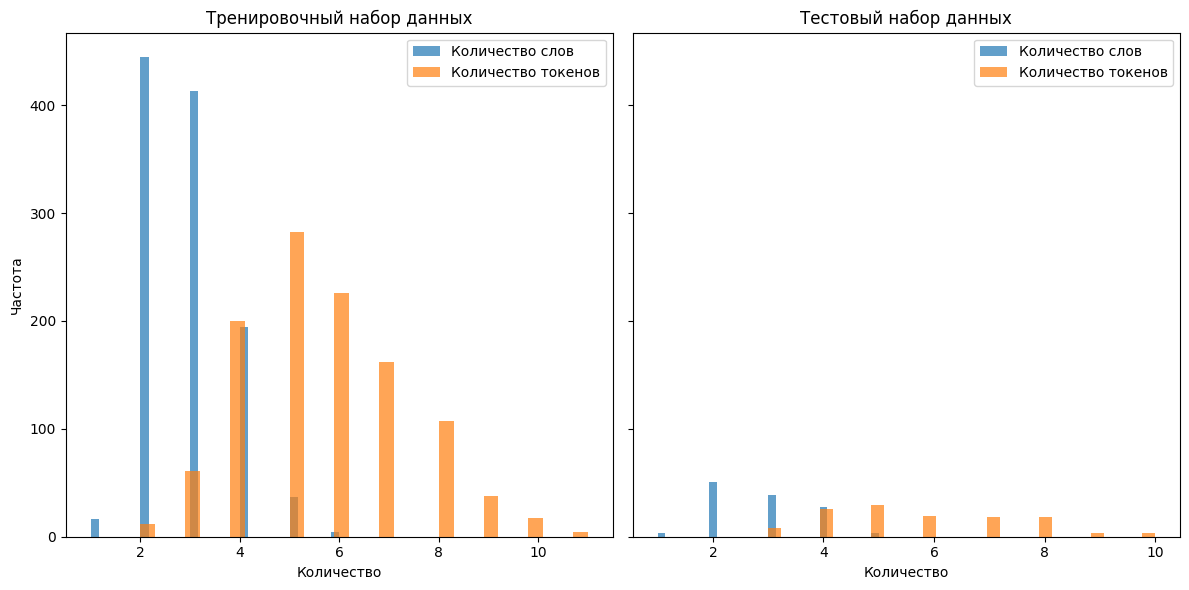

In [30]:
import matplotlib.pyplot as plt

# Подсчет количества слов и токенов с использованием токенизатора
train_word_counts = [len(example['input'].split()) for example in dataset_2['train']]
train_token_counts = [len(t5_ft_tokenizer.tokenize(example['input'])) for example in dataset_2['train']]

test_word_counts = [len(example['input'].split()) for example in dataset_2['test']]
test_token_counts = [len(t5_ft_tokenizer.tokenize(example['input'])) for example in dataset_2['test']]

# Визуализация результатов
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Гистограмма для тренировочного набора данных
axes[0].hist(train_word_counts, bins=30, alpha=0.7, label='Количество слов')
axes[0].hist(train_token_counts, bins=30, alpha=0.7, label='Количество токенов')
axes[0].set_title('Тренировочный набор данных')
axes[0].set_xlabel('Количество')
axes[0].set_ylabel('Частота')
axes[0].legend()

# Гистограмма для тестового набора данных
axes[1].hist(test_word_counts, bins=30, alpha=0.7, label='Количество слов')
axes[1].hist(test_token_counts, bins=30, alpha=0.7, label='Количество токенов')
axes[1].set_title('Тестовый набор данных')
axes[1].set_xlabel('Количество')
axes[1].legend()

plt.tight_layout()
plt.show()

In [31]:
MAX_LENGTH = 16
# Токенизация
def preprocess_batch(batch):
    model_inputs = t5_ft_tokenizer(
        batch['input'],
        truncation=True,
        max_length=MAX_LENGTH,
        padding='max_length'
    )
    with t5_ft_tokenizer.as_target_tokenizer():
        labels = t5_ft_tokenizer(
            batch['target'],
            truncation=True,
            max_length=MAX_LENGTH,
            padding='max_length'
        )
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

dataset_2_tok = dataset_2.map(
    preprocess_batch,
    batched=True,
    remove_columns=['input', 'target', '__index_level_0__']
)

Map:   0%|          | 0/1109 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4007: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/124 [00:00<?, ? examples/s]

In [32]:
dataset_2_tok['train']

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1109
})

### Дообучение

In [33]:
dataset.set_format(type='torch', device='cuda')

In [34]:
# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=t5_ft_tokenizer,
    model=t5_ft_model,
    padding='longest'
)

output_dir = "./models/t5-russian-spell-ft"

# Аргументы обучения
training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type="linear",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    predict_with_generate=True,
    fp16=torch.cuda.is_available(),   # ускорение на GPU
    gradient_accumulation_steps=1,
    report_to=[]                      # без wandb
)

# Trainer
trainer = Seq2SeqTrainer(
    model=t5_ft_model,
    args=training_args,
    train_dataset=dataset_2_tok['train'],
    eval_dataset=dataset_2_tok['test'],
    data_collator=data_collator,
    tokenizer=t5_ft_tokenizer,
)

# Запускаем обучение
trainer.train()

# Сохраняем дообученную модель
trainer.save_model(output_dir)
t5_ft_tokenizer.save_pretrained(output_dir)

/tmp/ipython-input-797034621.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss
50,3.207500
100,0.270400
150,0.212600
200,0.171800


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:4034: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 256}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


('./models/t5-russian-spell-ft/tokenizer_config.json',
 './models/t5-russian-spell-ft/special_tokens_map.json',
 './models/t5-russian-spell-ft/spiece.model',
 './models/t5-russian-spell-ft/added_tokens.json',
 './models/t5-russian-spell-ft/tokenizer.json')

Примените дообученную модель. Как раз здесь для оценки качества результата выведите на экран 10 текстов с предыдущего шага и их исправления с помощью модели.

In [35]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Загружаем дообученную модель
ft_path = output_dir
inf_tokenizer = AutoTokenizer.from_pretrained(ft_path)
inf_model = AutoModelForSeq2SeqLM.from_pretrained(ft_path).to(device)
inf_model.eval()

# Применение модели к 10 примерам
# возьмём 10 транскриптов Whisper (оригинальные .txt без _t5 и не _t5_ft)
txt_files = [p for p in (DATA_ROOT).glob("*.txt") if not p.name.endswith("_t5.txt") and not p.name.endswith("_t5_ft.txt")]
sample_txt_files = random.sample(txt_files, k=min(10, len(txt_files)))

print("10 примеров: Whisper -> Fine-tuned T5")
print("="*60)
for p in sample_txt_files:
    src = p.read_text(encoding="utf-8").strip()
    inputs = inf_tokenizer(src, return_tensors="pt").to(inf_model.device)
    with torch.no_grad():
        gen_ids = inf_model.generate(**inputs, max_length=64)
    pred = inf_tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    # путь к файлу с исправлениями предобученной T5 (из Шага 2)
    t5_file = (DATA_ROOT / f"{p.stem}_t5.txt")
    t5_file_text = t5_file.read_text(encoding="utf-8").strip() if t5_file.exists() else "(нет файла)"

    print(f"Файл         : {p.name}")
    print(f"Whisper      : {src}")
    print(f"T5 original  : {t5_file_text}")  # содержимое *_t5.txt для визуального сравнения
    print(f"T5 fine-tuned: {pred}")
    print("-"*60)

10 примеров: Whisper -> Fine-tuned T5
Файл         : f9d9fa24-0e3c-430f-8e42-622a0fa0c6a5.txt
Whisper      : Кейт Буш.
T5 original  : Кейт Буш
T5 fine-tuned: Кейт Буш
------------------------------------------------------------
Файл         : 776a335c-4817-4ed4-8a63-4b88bfaf1c2d.txt
Whisper      : Мой сосед татура.
T5 original  : Мой сосед Татура.
T5 fine-tuned: Мой сосед Татура
------------------------------------------------------------
Файл         : c53908cc-adb1-418b-b68b-f67094fc4afd.txt
Whisper      : Брайан Адамс
T5 original  : Брайан Брайан Адамс
T5 fine-tuned: Брайан Адамс
------------------------------------------------------------
Файл         : eebe7151-43f7-4e5f-af3d-d7a1a3ab2197.txt
Whisper      : Александр Владимирович Попов
T5 original  : Александр Владимирович Попов
T5 fine-tuned: Александр Владимирович Попов
------------------------------------------------------------
Файл         : 537c7e5c-fda8-46f2-8395-4420dd34dec5.txt
Whisper      : Барьмонт, Костянкин Дмитрий.


### Применение дообученной модели ко всем файлам

In [36]:
# Обработаем все файлы моделью T5 fine-tuned
txt_files = [
    f for f in DATA_ROOT.rglob('*.txt')
    if not f.name.endswith('_t5.txt') and not f.name.endswith('_t5_ft.txt')
]

for txt_file in tqdm(txt_files):
    with open(txt_file, 'r', encoding='utf-8') as f:
        transcription = f.read().strip()
        input_ids = inf_tokenizer(transcription, return_tensors="pt").input_ids.to(inf_model.device)
        outputs = inf_model.generate(input_ids)
        corrected_text = inf_tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        new_filename = txt_file.stem + "_t5_ft.txt" 
        new_path = DATA_ROOT / new_filename
        with open(new_path, 'w', encoding='utf-8') as f:
            f.write(corrected_text)

  0%|          | 0/100 [00:00<?, ?it/s]

## Шаг 5 (1 балл)

Время считать метрики и возвращаться к дообучению модели по необходимости. В этом шаге мы оцениваем только выполнение задания, а не значения метрик.

a) [Здесь](https://disk.yandex.ru/d/SPJU3lCt_cMDcw) лежат правильные ответы почти на все аудио - считайте метрики только для аудио, для которых мы дали вам ответы. Посчитайте [WER](https://docs.pytorch.org/torcheval/main/generated/torcheval.metrics.WordErrorRate.html) для модели whisper-small.

б) Посчитайте WER для whisper-small + исправление опечаток предобученной моделью (модель выберите самостоятельно!)

в) Посчитайте WER для whisper-small + дообученная Вами модель (данные для дообучения и модель выберите самостоятельно!)

In [37]:
# ваш код здесь
import json

# Файл `result_array.json` как-то уже скачали в текущую директорию
with open('result_array.json', 'r', encoding='utf-8') as f:   
    result_array = json.load(f)
result_array[0]

{'url': 'http://storage.mds.yandex.net:80/get-voicetoloka/1872575/197f271b-b23f-4ee0-b240-e956a172d7af',
 'text': 'жизнь других'}

In [41]:
# Define a function to preprocess a single line
import re

def preprocess_line(line: str) -> str:
    """
    Preprocesses a single line of text by:
    1. Removing all punctuation except apostrophes.
    2. Converting the text to lowercase.

    Args:
        line (str): The input line of text to preprocess.

    Returns:
        str: The preprocessed line of text.
    """
    chars_to_ignore_regex = r'[\,\?\.\!\-\;\:\"]'

    line = re.sub(chars_to_ignore_regex, '', line)

    return line.lower()

In [42]:
from torcheval.metrics import WordErrorRate

wer_whisper = WordErrorRate()
wer_t5 = WordErrorRate()
wer_t5_ft = WordErrorRate()

# Для всех файлов из result_array
for item in result_array:
    file_name = item['url'].split('/')[-1]
    reference = preprocess_line(item['text'])
    
    # Whisper
    try:
        with open(DATA_ROOT / (file_name + '.txt'), 'r', encoding='utf-8') as f:
            whisper_pred = preprocess_line(f.read().strip())
        wer_whisper.update(reference, whisper_pred)
    except FileNotFoundError:
        continue
    
    # T5 original
    try:
        with open(DATA_ROOT / (file_name + '_t5.txt'), 'r', encoding='utf-8') as f:
            t5_pred = preprocess_line(f.read().strip())
        wer_t5.update(reference, t5_pred)
    except FileNotFoundError:
        continue
    
    # T5 fine-tuned
    try:
        with open(DATA_ROOT / (file_name + '_t5_ft.txt'), 'r', encoding='utf-8') as f:
            t5_ft_pred = preprocess_line(f.read().strip())
        wer_t5_ft.update(reference, t5_ft_pred)
    except FileNotFoundError:
        continue

print(f"WER Whisper: {wer_whisper.compute():.4f}")
print(f"WER Whisper+T5 original: {wer_t5.compute():.4f}")
print(f"WER Whisper+T5 fine-tuned: {wer_t5_ft.compute():.4f}")

WER Whisper: 0.3974
WER Whisper+T5 original: 0.8306
WER Whisper+T5 fine-tuned: 0.4113


## Шаг 6 (3 балла)

В этом шаге предлагаем вам провести максимум рисерча и экспериментов для наиболее качественного решения задачи (в бесплатном google colab, без привлечения дополнительных мощностей)

* Поищите предобученные модели, применение которых для задачи speech-to-text дает меньше опечаток (меньше WER)

* Протестируйте несколько spell-correction моделей и сделайте выводы какая из них лучше (с точки зрения WER)

* Возьмите лучшую из найденных моделей и попытайтесь улучшить ее через шаг 4, как делали ранее. Попробуйте немного изменить обучение в шаге 4, чтобы добиться еще более хороших результатов (изменить данные/гиперпараметры и т.п.) и проведите соответствующий эксперимент. Объясните почему ваша модификация шага 4 теоретически может улучшить результаты и сделайте выводы о том, получилось ли улучшить качество (если нет, то предположите почему).

В 6-м шаге достаточно если сделал:
- применил STT модель посильнее
- попробовал алаймент результатов на паре открытых моделек (качество не оч)
- взял одну из этих моделек и пофайнтюнил на своем датасете из п.4 ДЗ не доводя до конвергенции. То есть просто показал что файнтюнится, становится лучше и тп (к тому же модельку я взял файнтюнить вообще для англ языка)

В целом достаточно! Ну надо текстом написать подробно выводы только

In [ ]:
# ваши эксперименты здесь